# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## Project Overview

Sparkify is a music streaming company similar to Spotify or Apple music. The business model is based on the users having a free or premium subscription. The user at any time can downgrade their subscription to free or cancel. The interactions the user has with the system are monitored and logged by the system.

The project's goal is to identify users at risk of canceling the service by using the system's data. Identifying these users before they cancel will help Sparkify increase retention and maintain the business's bottom line.

## Problem Statement

The first step is to explore the data, clean the data, and identify users who have churn. After performing the first step, the data will be visualized to explore various columns and identify these users' patterns. In the third step, features will be created from the data to predict if a user will churn. Finally, various machine learning models will be fitted and tested. The best model will be selected to assist Sparkify in identifying users who might churn in the future.

## Metrics

The dataset is imbalanced because around 22% percent of users have canceled the service. The metric that will be used for the best model is the F1 Score. The metric will give a better measure of incorrectly classifying a case. Additionally, we will also output the accuracy and AOC area under the curve that can be used to grade the model.



Importing libraries that will be used in the project.

In [1]:
from pyspark.sql.functions import isnan, when, count, col, desc, udf, split,countDistinct, to_date,avg,asc,round
from pyspark.sql.types import IntegerType, TimestampType
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

sns.set(rc={'figure.figsize':(15, 10)})
sns.set(font_scale=1)
sns.set_style("whitegrid")


Created function start spark. Mostly used as I move to the bottom of the Ipython note book.

In [4]:
def create_session():
    """Creates a spark sesion.

    Returns:
        obj: Spark session.
    """
    spark = SparkSession.builder.appName('sparkify').getOrCreate()
    return spark
spark = create_session()    

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

Will load dataset to Spark and display two records.

In [5]:
data_path ='mini_sparkify_event_data.json'
sdf = spark.read.json(data_path)
sdf.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

printed the schema of the dataset and total columns and rows of the dataset.

In [6]:
print("Total Rows: ",sdf.count())
print("Total Columns: ",len(sdf.columns))

Total Rows:  286500
Total Columns:  18


In [12]:
sdf.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Below is the count of both null and missing values of the loaded dataframe in spark and a descriptive summary.
* artist is missing 58392 values
* firstName is missing 8346 values
* gender is missing 58392 values
* lastName is missing 8346 values
* length is missing 58392 values
* location is missing 8346 values
* registration is missing 8346 values
* song is missing 58392 values
* userAgent is missing 8346 values

In [77]:
sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
    for c in sdf.columns]).show()


+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [19]:
sdf.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

All the cells below summarise the categories of the dataset.

In [27]:
sdf.groupby('artist').agg({'artist':'count'}).sort(desc('count(artist)'))\
    .show(n=25)

+--------------------+-------------+
|              artist|count(artist)|
+--------------------+-------------+
|       Kings Of Leon|         1841|
|            Coldplay|         1813|
|Florence + The Ma...|         1236|
|       Dwight Yoakam|         1135|
|            BjÃÂ¶rk|         1133|
|      The Black Keys|         1125|
|                Muse|         1090|
|       Justin Bieber|         1044|
|        Jack Johnson|         1007|
|              Eminem|          953|
|           Radiohead|          884|
|     Alliance Ethnik|          876|
|               Train|          854|
|        Taylor Swift|          840|
|         OneRepublic|          828|
|         The Killers|          822|
|         Linkin Park|          787|
|         Evanescence|          781|
|            Harmonia|          729|
|       Guns N' Roses|          713|
|           Daft Punk|          713|
|           Metallica|          697|
|          John Mayer|          693|
|Barry Tuckwell/Ac...|          643|
|

In [28]:
sdf.groupby('auth').agg({'auth':'count'}).sort(desc('count(auth)'))\
    .show()

+----------+-----------+
|      auth|count(auth)|
+----------+-----------+
| Logged In|     278102|
|Logged Out|       8249|
|     Guest|         97|
| Cancelled|         52|
+----------+-----------+



In [31]:
sdf.groupby('firstName').agg({'firstName':'count'})\
    .sort(desc('count(firstName)')).show(n=10)

+---------+----------------+
|firstName|count(firstName)|
+---------+----------------+
|   Payton|            9632|
|    Riley|            7970|
|   Lucero|            6880|
|   Emilia|            5732|
|     Emma|            5478|
|   Joseph|            5209|
|    Colin|            4989|
|   Nicole|            4825|
|   Joshua|            4654|
|  Brayden|            4621|
+---------+----------------+
only showing top 10 rows



In [25]:
sdf.groupby('gender').agg({'gender':'count'})\
    .sort(desc('count(gender)')).show()

+------+-------------+
|gender|count(gender)|
+------+-------------+
|     F|       154578|
|     M|       123576|
|  null|            0|
+------+-------------+



In [32]:
sdf.groupby('Level').agg({'Level':'count'})\
    .sort(desc('count(Level)')).show()

+-----+------------+
|Level|count(Level)|
+-----+------------+
| paid|      228162|
| free|       58338|
+-----+------------+



In [33]:
sdf.groupby('location').agg({'location':'count'})\
    .sort(desc('count(location)')).show()

+--------------------+---------------+
|            location|count(location)|
+--------------------+---------------+
|Los Angeles-Long ...|          30131|
|New York-Newark-J...|          23684|
|Boston-Cambridge-...|          13873|
|Houston-The Woodl...|           9499|
|Charlotte-Concord...|           7780|
|Dallas-Fort Worth...|           7605|
|Louisville/Jeffer...|           6880|
|Philadelphia-Camd...|           5890|
|Chicago-Napervill...|           5114|
|    St. Louis, MO-IL|           4858|
|Phoenix-Mesa-Scot...|           4846|
|Vineland-Bridgeto...|           4825|
|          Wilson, NC|           4659|
|Denver-Aurora-Lak...|           4453|
|           Ionia, MI|           4428|
|San Antonio-New B...|           4373|
|        Danville, VA|           4257|
|Atlanta-Sandy Spr...|           4236|
|New Haven-Milford...|           4007|
|         Jackson, MS|           3839|
+--------------------+---------------+
only showing top 20 rows



In [34]:
sdf.groupby('method').agg({'method':'count'})\
    .sort(desc('count(method)')).show()

+------+-------------+
|method|count(method)|
+------+-------------+
|   PUT|       261064|
|   GET|        25436|
+------+-------------+



In [35]:
sdf.groupby('page').agg({'page':'count'})\
    .sort(desc('count(page)')).show()

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|            NextSong|     228108|
|                Home|      14457|
|           Thumbs Up|      12551|
|     Add to Playlist|       6526|
|          Add Friend|       4277|
|         Roll Advert|       3933|
|               Login|       3241|
|              Logout|       3226|
|         Thumbs Down|       2546|
|           Downgrade|       2055|
|                Help|       1726|
|            Settings|       1514|
|               About|        924|
|             Upgrade|        499|
|       Save Settings|        310|
|               Error|        258|
|      Submit Upgrade|        159|
|    Submit Downgrade|         63|
|Cancellation Conf...|         52|
|              Cancel|         52|
+--------------------+-----------+
only showing top 20 rows



In [37]:
sdf.groupby('status').agg({'status':'count'})\
    .sort(desc('count(status)')).show()

+------+-------------+
|status|count(status)|
+------+-------------+
|   200|       259812|
|   307|        26430|
|   404|          258|
+------+-------------+



In [38]:
sdf.groupby('userAgent').agg({'userAgent':'count'})\
    .sort(desc('count(userAgent)')).show()


+--------------------+----------------+
|           userAgent|count(userAgent)|
+--------------------+----------------+
|"Mozilla/5.0 (Win...|           22751|
|"Mozilla/5.0 (Mac...|           19611|
|"Mozilla/5.0 (Mac...|           18448|
|"Mozilla/5.0 (Mac...|           17348|
|Mozilla/5.0 (Wind...|           16700|
|"Mozilla/5.0 (Win...|           15395|
|"Mozilla/5.0 (Win...|           14598|
|Mozilla/5.0 (Maci...|           10300|
|"Mozilla/5.0 (iPa...|            8912|
|Mozilla/5.0 (comp...|            8624|
|"Mozilla/5.0 (Mac...|            8094|
|"Mozilla/5.0 (Win...|            7923|
|"Mozilla/5.0 (Mac...|            7906|
|"Mozilla/5.0 (Win...|            7624|
|"Mozilla/5.0 (iPh...|            6417|
|Mozilla/5.0 (Wind...|            5989|
|"Mozilla/5.0 (Mac...|            5716|
|"Mozilla/5.0 (Win...|            5238|
|"Mozilla/5.0 (Win...|            4917|
|Mozilla/5.0 (Wind...|            4663|
+--------------------+----------------+
only showing top 20 rows



Their are users who have missing or null userids. These will be removed.

In [33]:
sdf.where((col('userId').isNull()) | (col('userId') == '')).show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

* Reloaded data
* Removed Guest records
* Removed Null or empty userId records
* Followed intructions and used Cancellation Confirmation as churn with udf funcion
* Extracted state
* Converted ts to date time column
* Extracted date
* Removed unwanted columns 

In [33]:
def load_clean_data(data_path: str):
    """Cleans and transforms dataset

    Args:
        data_path (str): Path of the dataset.

    Returns:
        obj: Spark dataFrame.
    """    
    spark = create_session()
    sdf = spark.read.json(data_path)
    sdf = sdf.filter(sdf['auth'] != 'Guest')
    sdf = sdf.where(~((col('userId').isNull()) | (col('userId') == '')))
    churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0,\
         IntegerType())
    sdf = sdf.withColumn('churn', churn_event('page'))
    sdf = sdf.withColumn('state', split(sdf['location'], ',')[1])
    sdf = sdf.withColumn('date_time', (col('ts') / 1000.0)\
        .cast(TimestampType()))
    sdf = sdf.withColumn('date', to_date('date_time'))
    sdf = sdf.drop(*['firstName', 'lastName','location','ts'])
    return sdf

data_path = 'mini_sparkify_event_data.json'
sdf_clean = load_clean_data(data_path)

Clean data after applying the steps.

In [15]:
sdf_clean.show(n=5)

+----------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+--------------------+------+-----+------+-------------------+----------+
|          artist|     auth|gender|itemInSession|   length|level|method|    page| registration|sessionId|                song|status|           userAgent|userId|churn| state|          date_time|      date|
+----------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+--------------------+------+-----+------+-------------------+----------+
|  Martha Tilston|Logged In|     M|           50|277.89016| paid|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|Mozilla/5.0 (Wind...|    30|    0|    CA|2018-09-30 20:01:57|2018-09-30|
|Five Iron Frenzy|Logged In|     M|           79|236.09424| free|   PUT|NextSong|1538331630000|        8|              Canada|   200|"Mozilla/5.0 (Win...|     9|    0| MA-NH|20

New schema

In [44]:
sdf_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- date: date (nullable = true)



Examples of churn cases.

In [14]:
sdf_clean.where(col('churn')== 1).show(10)

+------+---------+------+-------------+------+-----+------+--------------------+-------------+---------+----+------+--------------------+------+-----+------------+-------------------+----------+
|artist|     auth|gender|itemInSession|length|level|method|                page| registration|sessionId|song|status|           userAgent|userId|churn|       state|          date_time|      date|
+------+---------+------+-------------+------+-----+------+--------------------+-------------+---------+----+------+--------------------+------+-----+------------+-------------------+----------+
|  null|Cancelled|     M|          104|  null| paid|   GET|Cancellation Conf...|1535623466000|      514|null|   200|"Mozilla/5.0 (Mac...|    18|    1|       MO-KS|2018-10-07 16:26:30|2018-10-07|
|  null|Cancelled|     M|           56|  null| paid|   GET|Cancellation Conf...|1537167593000|      540|null|   200|"Mozilla/5.0 (iPh...|    32|    1|          AZ|2018-10-08 17:10:46|2018-10-08|
|  null|Cancelled|     M|

Function to help plot churn.

In [37]:
def frequency_plot(data, group, title, flip=False ):
    """Plots the frequency of a category by churn.

    Args:
        data (DataFrame): Data for chart.
        group (str): Grouping variable.
        title (str): Chart tittle.
        flip (bool, optional): Transposes the chart. Defaults to False.
    """
    plot_df = data.groupby(['churn', group]).agg(countDistinct('userId')\
        .alias('count')).toPandas()
    
    if flip:
        sns.barplot(data=plot_df, x='count', y=group,hue='churn')\
            .set_title(title)
    else:
        sns.barplot(data=plot_df, y='count', x=group,hue='churn')\
            .set_title(title)

def summary_plot(data, group, title, flip=False):
    """Plots the total frequency by category.

    Args:
        data (DataFrame): Data for chart.
        group (str): Grouping variable.
        title (str): Chart tittle.
        flip (bool, optional): Transposes the chart. Defaults to False.
    """   

    plot_df = data.groupby([group]).agg(count('page')\
        .alias('count')).sort(desc('count'))\
            .toPandas().nlargest(25, 'count') 
    
    if flip:
        sns.barplot(data=plot_df, x='count', y=group,\
             color="royalblue")\
            .set_title(title)
    else:
        sns.barplot(data=plot_df, y='count', x=group,\
             color="royalblue")\
            .set_title(title)

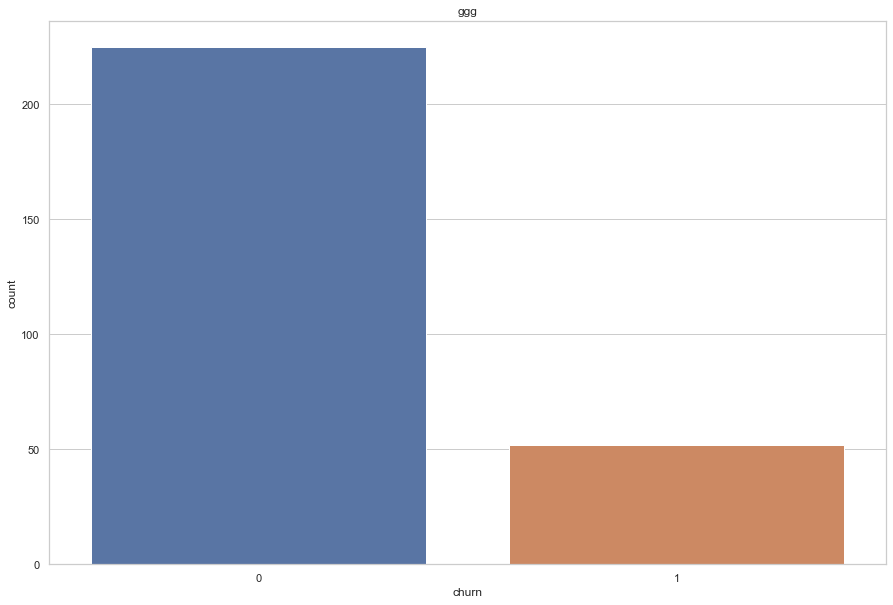

In [26]:
chart_data = sdf_clean.groupby(['churn',]).agg(countDistinct('userId')\
        .alias('count')).toPandas()

sns.barplot(data=chart_data, y='count', x='churn')\
            .set_title("Churn summary");

Their are a total of 225 unique users with 52 having a status of churn. The percentage that represents churn is 23% of the population.

In [49]:
sdf_clean.groupby(['churn']).agg(countDistinct('userId')\
        .alias('count')).toPandas()

,churn,count
0,1,52
1,0,225


Summary of top 25 artist

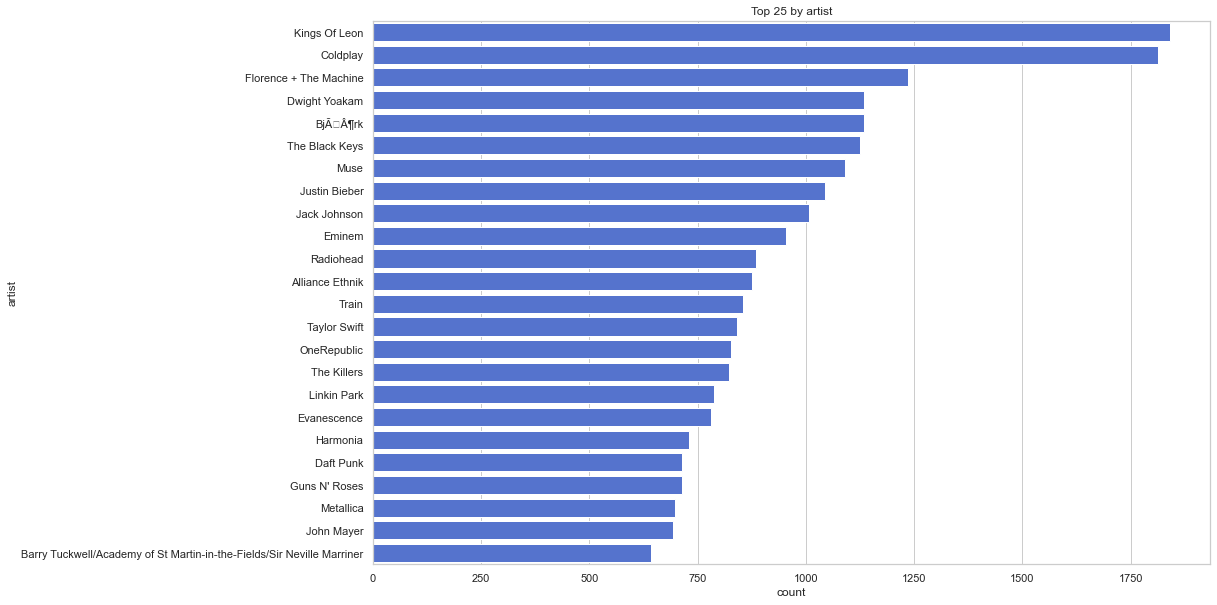

In [50]:
summary_plot(sdf_clean, 'artist', 'Top 25 by artist', flip=True)

Summary of top 25 songs

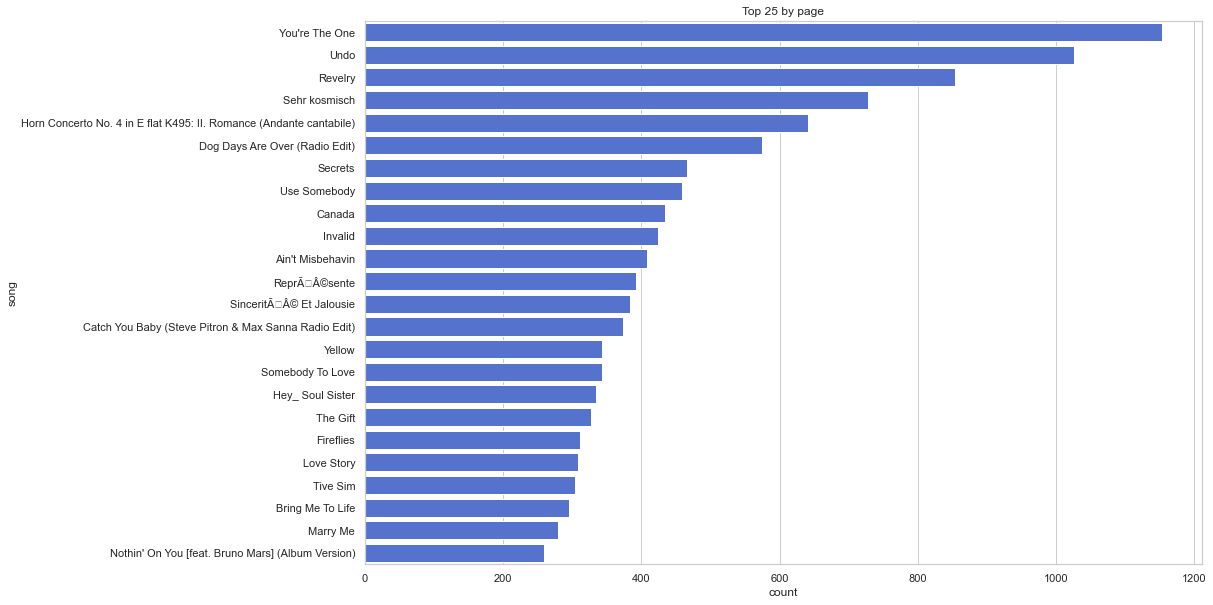

In [43]:
summary_plot(sdf_clean, 'song', 'Top 25 by songs', flip=True)

Summary of top 25 userAgent

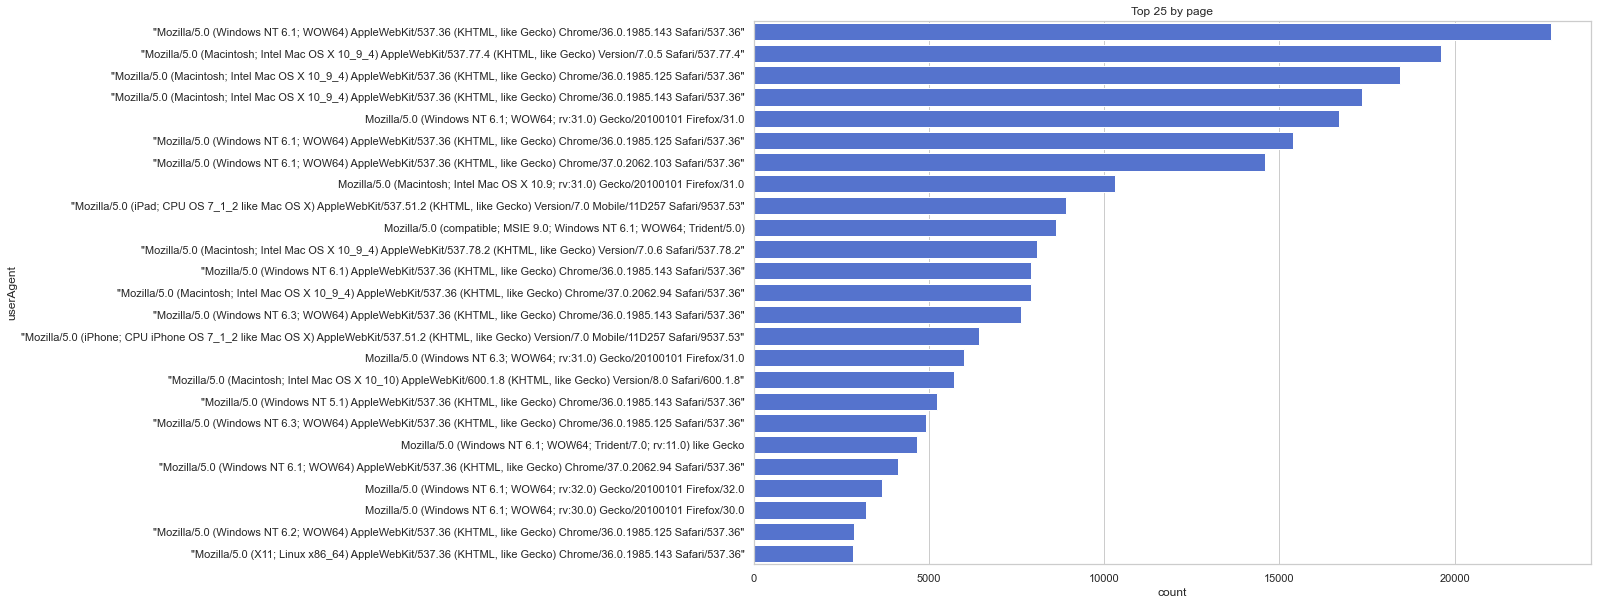

In [46]:
summary_plot(sdf_clean, 'userAgent', 'Top 25 by userAgent', flip=True)

* Summary of top 25 users
* User 39,140,92 seem to be over represented in the data

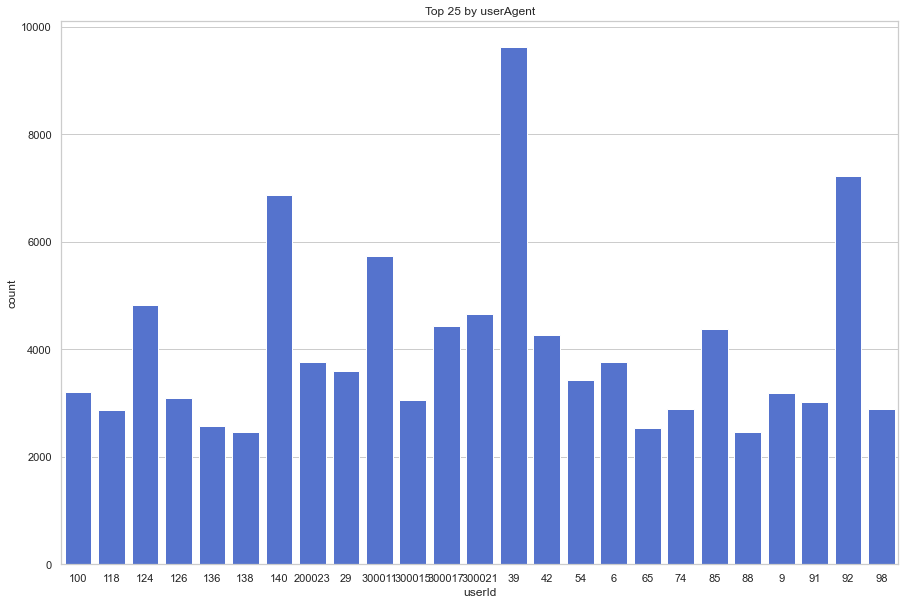

In [48]:
summary_plot(sdf_clean, 'userId', 'Top 25 by userAgent', flip=False)

* Summary of top 25 users
* The most popular activity is playing next song

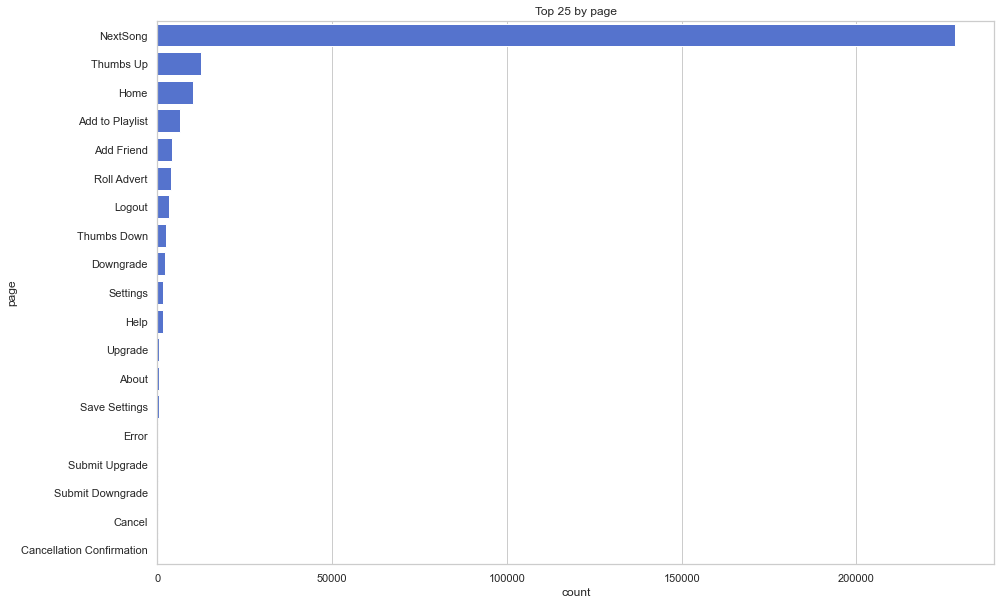

In [39]:
summary_plot(sdf_clean, 'page', 'Top 25 by page', flip=True)

* The charts below are summary of unique users by a category
* The charts below indicate that the dataset is inbalance
* Users that are part of the free service are also churning
* All users that churn did not have issues with the service

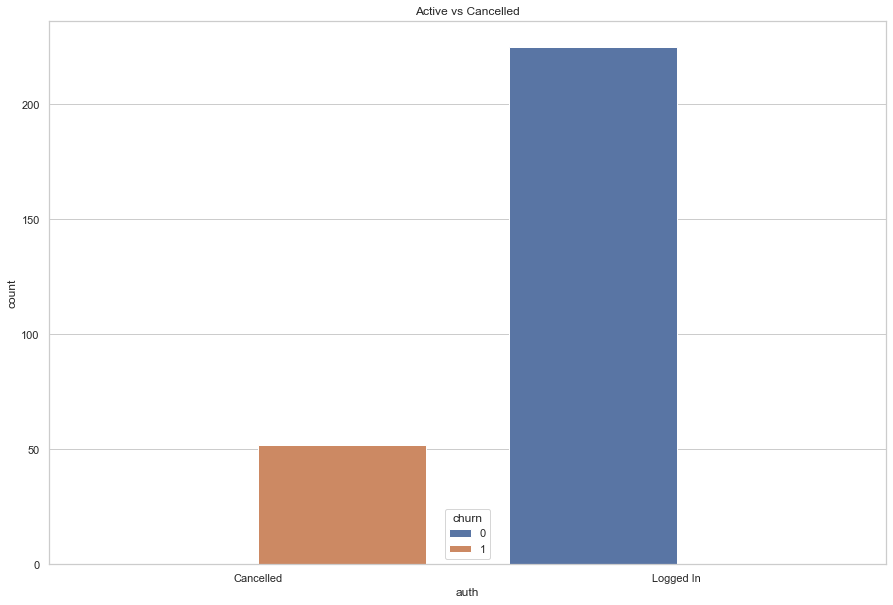

In [50]:
frequency_plot(sdf_clean, 'auth', 'Active vs Cancelled')

More males are churning compared to females.

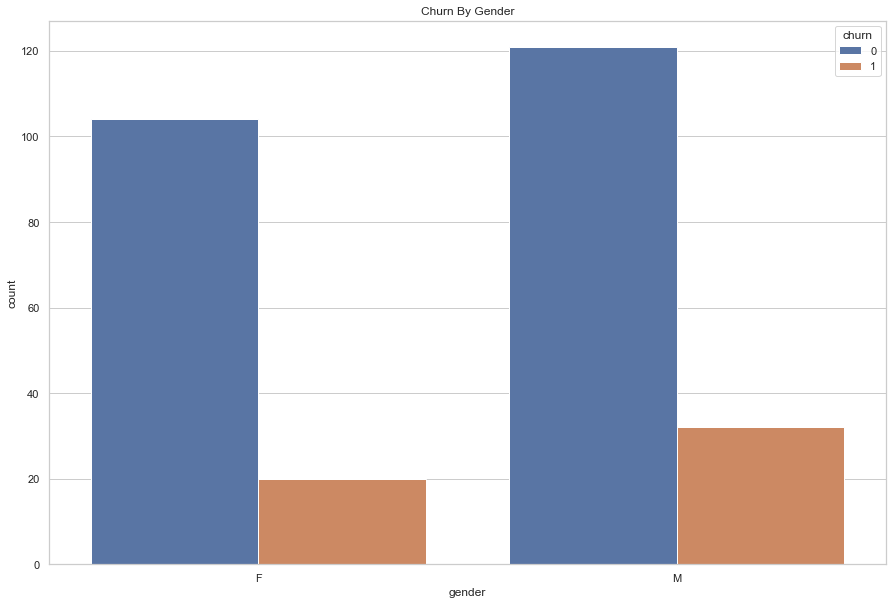

In [51]:
frequency_plot(sdf_clean, 'gender', 'Churn By Gender')

Users in the free level are also churning.

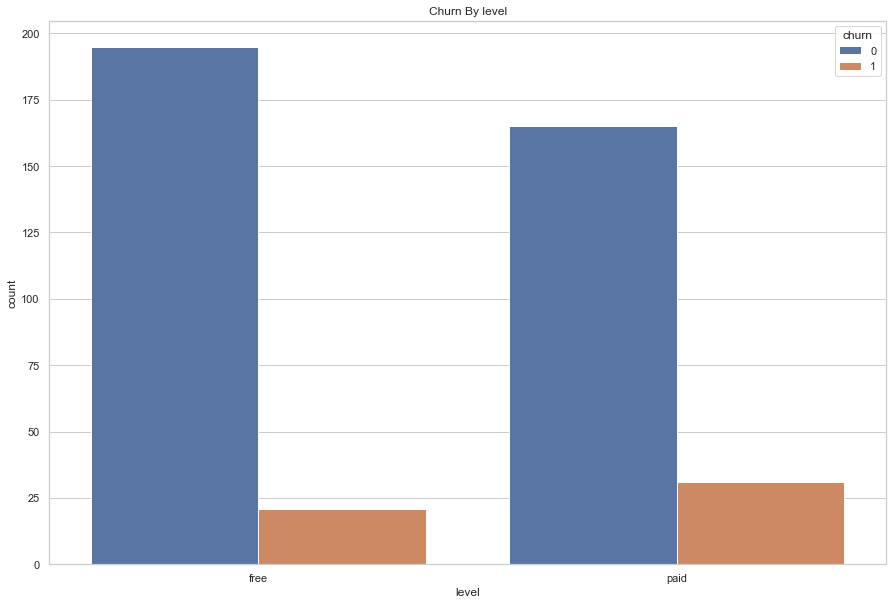

In [53]:
frequency_plot(sdf_clean, 'level', 'Churn By level')

User who churn are mostly getting information. The below will not be transformed into a feature.

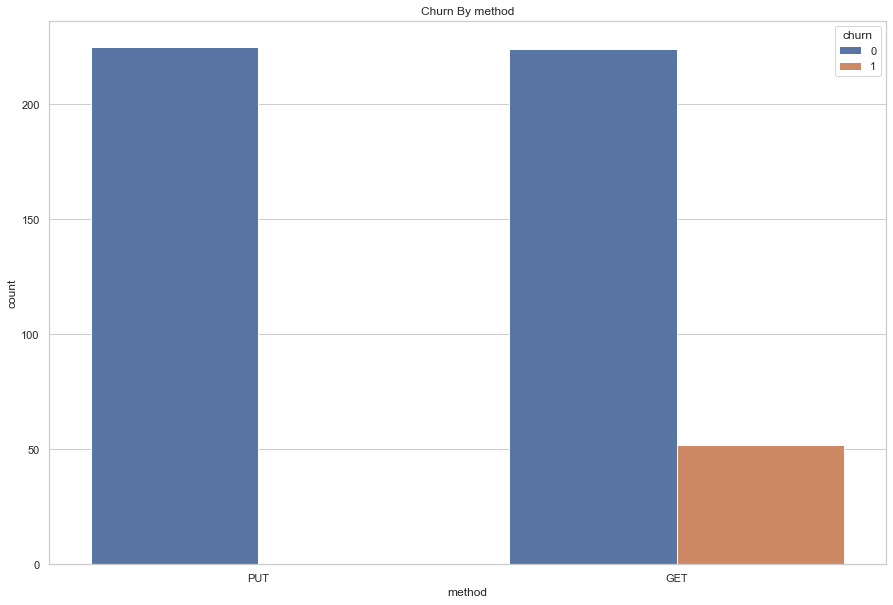

In [54]:
frequency_plot(sdf_clean, 'method', 'Churn By method')

Suprisingly usere who churn did not have issues with the system.

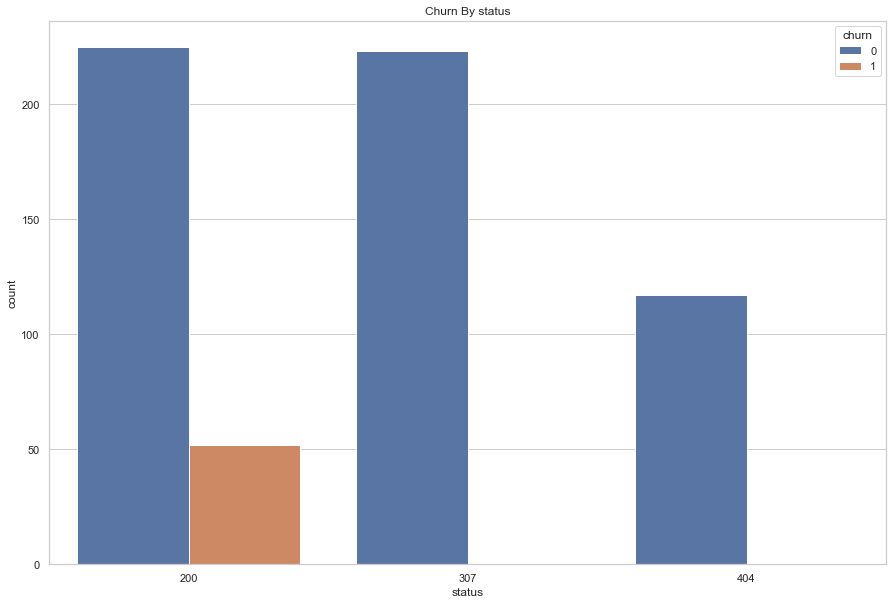

In [60]:
frequency_plot(sdf_clean, 'status', 'Churn By status')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

* Below I created and displayed the features that will be used in the model
* The features created focus on users interaction, gender and login into the service

In [127]:
churn_data = sdf_clean.select('userId', col('churn')).dropDuplicates()\
    .groupby('userId').agg({"churn":"max"})\
        .withColumnRenamed("max(churn)", "label")
churn_data.show(n=5)


+------+-----+
|userId|label|
+------+-----+
|200002|    0|
|100010|    0|
|   125|    1|
|     7|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



In [24]:
gender = sdf_clean.select("userId", "gender")\
    .dropDuplicates().replace(['M', 'F'], ['0', '1'], 'gender')\
        .select('userId', col('gender').cast('int'))
gender.show(n=5)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
+------+------+
only showing top 5 rows



In [25]:
friend_count = sdf_clean.where(sdf.page == 'Add Friend')\
    .groupby('userId').agg(count('userId').alias('friend_count'))
friend_count.show(n=5)

+------+------------+
|userId|friend_count|
+------+------------+
|100010|           4|
|200002|           4|
|    51|          28|
|   124|          74|
|     7|           1|
+------+------------+
only showing top 5 rows



In [26]:
playlist_count = sdf_clean.where(sdf.page == 'Add to Playlist')\
    .groupby('userId').agg(count('userId').alias('playlist_count'))
playlist_count.show(n=5)

+------+--------------+
|userId|playlist_count|
+------+--------------+
|100010|             7|
|200002|             8|
|    51|            52|
|   124|           118|
|     7|             5|
+------+--------------+
only showing top 5 rows



In [12]:
song_count = sdf_clean.where(sdf.page == 'NextSong')\
    .groupby('userId').agg(count('userId').alias('song_count'))
song_count.show(n=5)

+------+----------+
|userId|song_count|
+------+----------+
|100010|       275|
|200002|       387|
|   125|         8|
|    51|      2111|
|   124|      4079|
+------+----------+
only showing top 5 rows



In [19]:
thumbsup_count = sdf_clean.where(sdf.page=='Thumbs Up')\
    .groupby("userId").agg(count('page').alias('thumbsup_count'))
thumbsup_count.show(n=5)

+------+-------------+
|userId|thumbsUpCount|
+------+-------------+
|100010|           17|
|200002|           21|
|    51|          100|
|   124|          171|
|     7|            7|
+------+-------------+
only showing top 5 rows



In [20]:
thumbsdown_count = sdf_clean.where(sdf.page=='Thumbs Down')\
    .groupby("userId").agg(count('page').alias('thumbsdown_count'))
thumbsdown_count.show(n=5)

+------+----------------+
|userId|thumbsdown_count|
+------+----------------+
|100010|               5|
|200002|               6|
|    51|              21|
|   124|              41|
|     7|               1|
+------+----------------+
only showing top 5 rows



In [76]:
avg_daily_sessions = sdf_clean.select('userId', 'date', 'sessionId')\
    .dropDuplicates().groupby('userId', 'date')\
        .agg(count('sessionId').alias('count'))\
            .groupby('userId')\
                .agg(round(avg('count')).alias('avg_daily_sessions'))

avg_daily_sessions.show(n=5) 

+------+------------------+
|userId|avg_daily_sessions|
+------+------------------+
|200002|               1.0|
|100010|               1.0|
|   125|               1.0|
|    51|               1.0|
|   124|               1.0|
+------+------------------+
only showing top 5 rows



Created a function that captures the all the steps above. The function will return a merged Dataframe of features with users and if they have churned.

In [51]:
def features(sdf_clean):
    """Creates all features from the clean dataset.

    Args:
        sdf_clean (DataFrame): Spark DataFrame

    Returns:
        DataFrame: Spark DataFrame containing all created features.
    """
    churn_data = sdf_clean.select('userId', col('churn')).dropDuplicates()\
        .groupby('userId')\
        .agg({"churn": "max"}).withColumnRenamed("max(churn)", "label")

    gender = sdf_clean.select("userId", "gender").dropDuplicates()\
        .replace(['M', 'F'], ['0', '1'], 'gender').select('userId', \
            col('gender')\
            .cast('int'))

    friend_count = sdf_clean.where(sdf_clean.page == 'Add Friend').groupby('userId')\
        .agg(count('userId').alias('friend_count'))

    playlist_count = sdf_clean.where(sdf_clean.page == 'Add to Playlist')\
        .groupby('userId')\
        .agg(count('userId')\
        .alias('playlist_count'))

    song_count = sdf_clean.where(sdf_clean.page == 'NextSong').groupby('userId')\
        .agg(count('userId')\
        .alias('song_count'))

    thumbsup_count = sdf_clean.where(sdf_clean.page=='Thumbs Up').groupby("userId")\
        .agg(count('page')\
        .alias('thumbsup_count'))

    thumbsdown_count = sdf_clean.where(sdf_clean.page=='Thumbs Down')\
        .groupby("userId").agg(count('page')\
        .alias('thumbsdown_count'))

    avg_daily_sessions = sdf_clean.select('userId', 'date', 'sessionId')\
        .dropDuplicates()\
        .groupby('userId', 'date').agg(count('sessionId').alias('count'))\
        .groupby('userId').agg(round(avg('count')).alias('avg_daily_sessions'))
    
    features = churn_data.join(gender, "userId").join(friend_count, "userId")\
        .join(playlist_count, "userId")\
        .join(song_count, "userId").join(thumbsup_count, "userId")\
        .join(thumbsdown_count, "userId").join(avg_daily_sessions, "userId")

    return features

features_df = features(sdf_clean)

Exported features DataFrame and displayed top records.

In [130]:
# data = features_df.toPandas()
# data.to_csv("output_File.csv")

In [5]:
features_df.show(n=5)

+------+-----+------+------------+--------------+----------+--------------+----------------+------------------+
|userId|label|gender|friend_count|playlist_count|song_count|thumbsup_count|thumbsdown_count|avg_daily_sessions|
+------+-----+------+------------+--------------+----------+--------------+----------------+------------------+
|100010|    0|     1|           4|             7|       275|            17|               5|               1.0|
|200002|    0|     0|           4|             8|       387|            21|               6|               1.0|
|   124|    0|     1|          74|           118|      4079|           171|              41|               1.0|
|    51|    1|     0|          28|            52|      2111|           100|              21|               1.0|
|     7|    0|     0|           1|             5|       150|             7|               1|               1.0|
+------+-----+------+------------+--------------+----------+--------------+----------------+------------

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Various functions were created to assist in fitting and evaluating the models. Before refactoring the code, the test and train data set were erroneous and kept all features such as the assembler and the feature column. The issue was corrected but had refit models, which yield different results from the first fitting. In the first run, the SVM model was performing better than the GBT.

## Preprocessing
Before fitting a model a Vector assembler is created and the all the features are scaled using the StandadScaler. Scaling will normalize the features for better model performance.The data will also be split by train and test. The function feature_processing will help with the step.

To fit the model fit_model function has been created.




In [52]:
def feature_processing(features_df, columns, full_data=False):
    """Scales and prepares features  for fitting.

    Args:
        features_df (DataFrame): Spark DataFrame containing features.
        columns (list): List of column names.
        full_data (bool, optional): All data identifyer. Defaults to False.

    Returns:
        DataFrame|Multiple DataFrames: Returns training data.
    """
    # VectorAssembler
    assembler = VectorAssembler(inputCols=columns, outputCol="features")
    data = assembler.transform(features_df)

    # scale data
    scaler = StandardScaler(inputCol ='features', \
        outputCol ="final_features", withStd = True)
    scaler_model = scaler.fit(data)
    scale_data = scaler_model.transform(data)

    #Final features
    final_data = scale_data.select(scale_data.label,\
         scale_data.final_features.alias("features"))

    if full_data:
        return final_data
    else:
        train, test =final_data.randomSplit([0.80, 0.20], seed = 143)

        return train, test
        

def fit_model(data, classifier):
    """Fits model to training data.

    Args:
        data (DataFrame): Data to be fitted to model.
        classifier (obj): Classifier to fit data.

    Returns:
        obj: fitted model.
    """
    model_fit = classifier.fit(data)

    return model_fit


def test_model(model_fit, test_data):
    """Compares fitted model to test data.

    Args:
        model_fit (obj): Fitted model.
        test_data (DataFrame): Data to test the fitted model.
    """
    model_results = model_fit.transform(test_data)

    model_evaluation = MulticlassClassificationEvaluator(predictionCol\
        ='prediction')
    model_evaluation_auc = BinaryClassificationEvaluator(labelCol='label',\
         rawPredictionCol='prediction')

    print('Model Metrics')
    print('Accuracy: ', model_evaluation.evaluate(model_results, \
        {model_evaluation.metricName: 'accuracy'}))
    print('F-1 Score: ', model_evaluation.evaluate(model_results, \
        {model_evaluation.metricName: 'f1'}))
    print('Area under ROC Curve: ', model_evaluation_auc.evaluate(model_results\
        , {model_evaluation_auc.metricName: 'areaUnderROC'}))


def feature_importance_plot(columns, model_fit):
    """Plots feature importance.

    Args:
        columns (list): List of features used in the model.
        model_fit (obj): Fitted model.
    """
    values = list(model_fit.featureImportances)

    my_dict = dict(zip(columns, values)).items()

    feature_df = pd.DataFrame(list(my_dict),columns=['Features', 'Importance'])\
        .sort_values('Importance', ascending=False)  

    sns.barplot(data=feature_df, y='Features', x='Importance', color="royalblue")\
        .set_title('Feature_Plot');

* Extracted the test and training dataset and passed the features as column
* The function will create a vector assembler, scale, and split the data using a seed of 143

In [53]:
cols = ["gender", "friend_count", "playlist_count", \
          'song_count','thumbsup_count','thumbsdown_count',\
              'avg_daily_sessions']

train, test = feature_processing(features_df =features_df, columns=cols)

# Testing the model
To test the model I created the test_model function. The function compares the fitted model against the test data. The test model results are then compared and accuray, F1 score and areaUnderROC are extracted. The testing strategy is to maximize F-1 score.

## Base GBT model
* The model is not optimized and will be used to benchmark the optimized version
* The base GBT model did not perform well F score is very low and AUC is 39 which is not optimal
* Clicking thumbsup and having friends in Sparkify are good indicators in the model
* Suprisingly avg daily log in is not a strong indicator
### Base model
The base GBT model had the below parameters. After testing the model F1 score was .55
* maxIter: 20
* maxDepth: 5
* maxBins 32
* minInstancesPerNode: 1

Model Metrics
Accuracy:  0.5897435897435898
F-1 Score:  0.5516956162117452
Area under ROC Curve:  0.39655172413793105


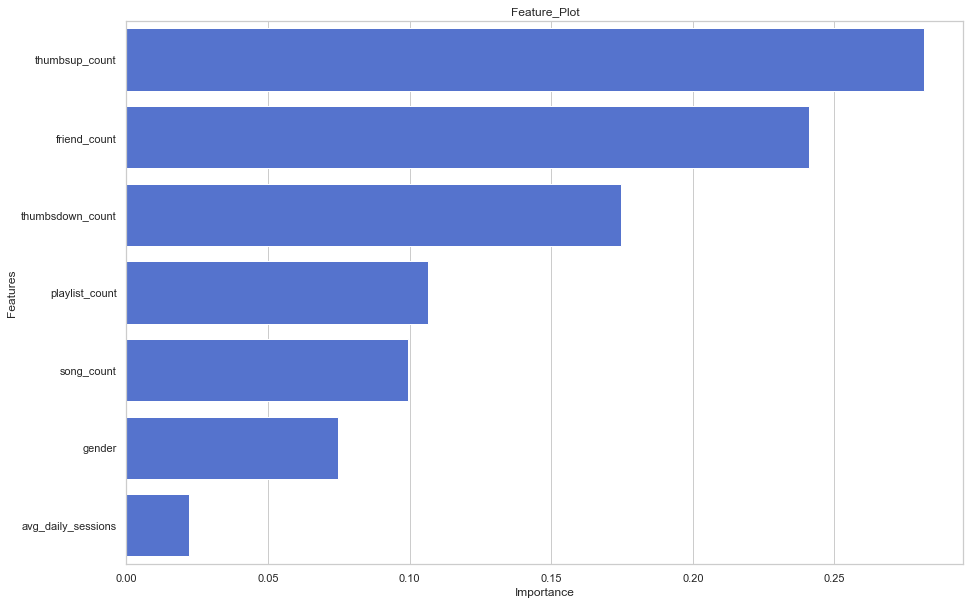

In [54]:
base_gbt = GBTClassifier()
gbt_fit = fit_model(data=train, classifier=base_gbt)
test_model(gbt_fit,test)
feature_importance_plot(columns=cols, model_fit=gbt_fit)

Base model details

In [57]:
gbt_fit.extractParamMap()

{Param(parent='GBTClassifier_807bbdd76cc2', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTClassifier_807bbdd76cc2', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTClassifier_807bbdd76cc2', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for r

## Base SVM
* The SVM model performed better than GBT
* The F-1 Score is larger wich is a good indicator that optimizing this model will yield better results

## Base model
The base svm model has the below parameters and yielded a F1 Score of .63 which was better than the base gbt model.

* aggregationDepth: 2
* maxIter: 100
* regParam: 0.0


In [58]:
base_svm = LinearSVC()
base_svm_fit = fit_model(data=train, classifier=base_svm)
test_model(base_svm_fit, test)

Model Metrics
Accuracy:  0.7435897435897436
F-1 Score:  0.6342383107088989
Area under ROC Curve:  0.5


Base model details

In [60]:
base_svm_fit.extractParamMap()

{Param(parent='LinearSVC_92dae0fba6bb', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LinearSVC_92dae0fba6bb', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LinearSVC_92dae0fba6bb', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearSVC_92dae0fba6bb', name='labelCol', doc='label column name.'): 'label',
 Param(parent='LinearSVC_92dae0fba6bb', name='maxIter', doc='max number of iterations (>= 0).'): 100,
 Param(parent='LinearSVC_92dae0fba6bb', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='LinearSVC_92dae0fba6bb', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
 Param(parent='LinearSVC_92dae0fba6bb', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
 Param(parent='LinearSVC_92dae0fba6bb', name='standardization', doc='whether to standardize the training features before fittin

# Best SVM
* Model perform same as base Model
* Selected this model as my final model
* I belive the model require more training time and maybe additional features

## hyper parameter
The below parameters were used to find the best svm.

* maxIter: (5, 10, 25)
* regParam: (0.1, 0.5, 0.9)


In [12]:
best_svm_model = LinearSVC()

best_svm_paramGrid = (ParamGridBuilder()
             .addGrid(best_svm_model.maxIter, [5, 10, 25])
             .addGrid(best_svm_model.regParam, [0.1, 0.5, 0.9])
             .build())

svmcv = CrossValidator(estimator = best_svm_model,
                      estimatorParamMaps = best_svm_paramGrid,
                      evaluator = MulticlassClassificationEvaluator(),
                      numFolds = 2)
svm_cv_fit = svmcv.fit(train)

test_model(svm_cv_fit.bestModel, test)

Model Metrics
Accuracy:  0.7435897435897436
F-1 Score:  0.6342383107088989
Area under ROC Curve:  0.5


# Best GBT
* Created a parametor grid to perform Hyperparameter tuning on the GBT model
* Due to how slow it is to train did not further explore additional parametors
* After fitting the model perform worst than the base model
maxDepth: (2, 5, 10)
maxBins: (10, 20, 40)
maxIter: (5, 10, 20)



In [59]:
#best model
# https://forums.databricks.com/questions/12097/pyspark-how-to-get-best-params-in-grid-search.html
# https://www.sparkitecture.io/machine-learning/classification/gradient-boosted-trees


best_gbt_model = GBTClassifier()

best_gbt_paramGrid = (ParamGridBuilder()
             .addGrid(best_gbt_model.maxDepth, [2, 5, 10])
             .addGrid(best_gbt_model.maxBins, [10, 20, 40])
             .addGrid(best_gbt_model.maxIter, [5, 10, 20])
             .build())

gbtcv = CrossValidator(estimator = best_gbt_model,
                      estimatorParamMaps = best_gbt_paramGrid,
                      evaluator = MulticlassClassificationEvaluator(),
                      numFolds = 2)
cv_fit = gbtcv.fit(train)

test_model(cv_fit.bestModel, test)

Model Metrics
Accuracy:  0.7435897435897436
F-1 Score:  0.7006639194139195
Area under ROC Curve:  0.5655172413793104


The best model was had aggregationDepth=2, maxIter=5, and regParam=0.1. I will fit the model to the full dataset and export the model.

In [16]:
# https://forums.databricks.com/questions/12097/pyspark-how-to-get-best-params-in-grid-search.html
print(cv_fit.bestModel)

GBTClassificationModel: uid = GBTClassifier_845afb2a78ca, numTrees=20, numClasses=2, numFeatures=7


In [14]:
cv_fit.bestModel.extractParamMap()

{Param(parent='GBTClassifier_845afb2a78ca', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTClassifier_845afb2a78ca', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTClassifier_845afb2a78ca', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for r

# Best Model
The best model was the GBTClassifier with the below parameters. The model name was `Best GBT` The final model was an improvement when compared to the other models. The F1 metric had a 15 point improvement compre to the base model, and 15 increase in accuracy. Additionally, the model 16.9 point improvement in AUC.
* maxIter: 20
* maxDepth: 2
* maxBins 40
* minInstancesPerNode: 1


| MODEL        | ACCURACY          | F1  | AUC |
|:---------------:|:-------------:|:------:|:----:|
| Base GBT      | 0.589 | 0.551 |0.396|
| Base SVM      | 0.743     |   0.634 |0.5|
| Best SVM        | 0.743      |    0.634 |0.5|
|  Best GBT    |   0.743       |  0.700    |  0.565   |

# Saving Final GBT model
Fitted model to all the data and save the model as best_GBTClassifier_model.

In [17]:
full_data = feature_processing(features_df =features_df, \
    columns=cols,full_data=True)

final_gbt_model = GBTClassifier(maxBins =40 ,maxDepth=2, maxIter=2)

final_gbt_fit = fit_model(data=full_data, classifier=final_gbt_model)

In [23]:
final_gbt_fit.save('best_GBTClassifier_model')

In [ ]:
SparkSession.stop

# Final Results

The best model was the GBTClassifier with the below parameters. The final model was an improvement when compared to the other models. The F1 metric had a 15 point improvement compared to the base model and 15 increase in accuracy; additionally, the model had a16.9 point improvement in AUC.

hyper parameter  for best model
maxIter: 20
maxDepth: 2
maxBins 40
minInstancesPerNode: 1

After hyperparameter tuning, the GBT model did perform better. There is evidence that this was due to the additional training. The numFolds was kept low to reduce training time for the project, especially after Identifying an issue with the training data where the models were using incorrect features. The results indicate that further training could improve the model. The total number of features gave the gradient boosting model a better performance than SVM. The increase in metrics might increase as the data gets bigger and more features are added.

Should additional training not increase model performance. More feature engineering could be required. For Example, identifying gaps at logon or just looking back a couple of weeks to see if the user behavior has changed.

# Reflection

The project was fascinating because it allows the data scientist to tackle a potential real-world scenario where not all the data fits into memory. Understanding user behavior was critical for the project to be successful. While the ideal model was not reached, insight into the data was achieved in the exploration and the model building phase. 

# Improvement

I think two areas of improvement that could be implemented are moving to the full dataset and training the model for a more extended period and additional hyperparameters. Moving the model to the full data set would undoubtedly change the exploratory analysis but yielding more patterns for the model to identify. Training would surely increase as data increased but also yielding a more accurate model.